In [11]:
import pandas as pd
import numpy as np
import ripser
import matplotlib.pyplot as plt
import umap
import math
import networkx as nx
import gudhi as gd
from gtda.mapper import CubicalCover, make_mapper_pipeline, Projection, plot_static_mapper_graph
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components
from matplotlib.cm import get_cmap
# Data viz
from gtda.plotting import plot_point_cloud
import matplotlib.patches as mpatches
np.random.seed(42)

def calculate_diameter(xyz_points):
    """Calculate the diameter of a 3D dataset (the largest distance between any two points)."""
    distances = pdist(xyz_points)
    max_distance = np.max(distances)
    L = round(max_distance)
    return L

def calculate_partitions(L, epsilon, alpha):
    """Calculate the number of partitions (N) for a given set length (L), partition length (epsilon), and overlap percentage (alpha)."""
    shift = epsilon * (1 - alpha / 100)
    N = math.floor((L - epsilon) / shift) + 1
    return N

def find_connected_components(data, R):
    """
    Finds connected components in the Vietoris-Rips complex.
    """
    from scipy.sparse.csgraph import connected_components
    from scipy.spatial.distance import pdist, squareform

    # Compute pairwise distances
    dist_matrix = squareform(pdist(data))

    # Create adjacency matrix
    adjacency_matrix = (dist_matrix <= R).astype(int)

    # Find connected components
    n_components, labels = connected_components(adjacency_matrix, directed=False)
    components = [data[labels == i] for i in range(n_components)]

    return components

# Define the functions (unchanged)
def plot_vietoris_rips_complex(data, R, label="data", col=1, maxdim=2):
    """
    Plots the Vietoris-Rips complex for a given set of points.
    """
    tab10 = get_cmap('tab10')  # Colormap for points
    viridis = get_cmap('viridis')  # Colormap for triangles

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Vietoris-Rips Complex (R = {R})")

    # Plot points with smaller size
    ax.scatter(
        data[:, 0], data[:, 1], label=label,
        s=20, alpha=0.9, c=np.array([tab10(col)] * len(data))  # Smaller dot size
    )

    # Step 1: Add lighter circles for each point
    for xy in data:
        ax.add_patch(mpatches.Circle(
            xy, radius=R, fill=False,
            edgecolor=tab10(col), alpha=0.1, linestyle='dotted'  # Lighter circles
        ))

    # Step 2: Draw edges (1-simplices)
    for i, xy in enumerate(data):
        for j in range(i + 1, len(data)):
            pq = data[j]
            if np.linalg.norm(xy - pq) <= R:
                ax.plot(
                    [xy[0], pq[0]], [xy[1], pq[1]],
                    color=tab10(col), alpha=0.6, linewidth=1
                )

    # Step 3: Draw triangles (2-simplices) if maxdim >= 2
    if maxdim >= 2:
        triangle_index = 0  # Index for assigning colors
        for i, xy in enumerate(data):
            for j in range(i + 1, len(data)):
                pq = data[j]
                if np.linalg.norm(xy - pq) <= R:
                    for k in range(j + 1, len(data)):
                        ab = data[k]
                        if (np.linalg.norm(xy - ab) <= R and
                            np.linalg.norm(pq - ab) <= R):
                            # All edges are within the threshold R
                            triangle = np.array([xy, pq, ab])
                            color = viridis(triangle_index / len(data))  # Unique color
                            ax.fill(
                                triangle[:, 0], triangle[:, 1],
                                color=color, alpha=0.5  # Adjust alpha for transparency
                            )
                            triangle_index += 1  # Update index for next triangle

    ax.axis('equal')
    plt.tight_layout()
    plt.show()

    # Find and return connected components
    components = find_connected_components(data, R)
    return components


def calculate_epsilon_for_betti_value_gd(persistence, resolution=1000):
    """
    Calculate the epsilon (threshold) at which Betti-1 reaches its maximum value.
    """
    x_values, betti_0, betti_1 = calculate_betti_curves_gd(persistence, resolution=resolution)
   
    # Find the index where Betti-1 is maximum using NumPy
    max_betti_1_index = np.argmax(betti_1)
   
    # Get the corresponding epsilon value
    epsilon_at_max_betti_1 = x_values[max_betti_1_index]
   
    return epsilon_at_max_betti_1, betti_1[max_betti_1_index]

def calculate_betti_curves(persistence_diagrams, resolution=1000):
    """
    Calculate Betti curves from a persistence diagram returned by ripser.

    Parameters:
        persistence_diagrams (list of arrays): Persistence diagrams from ripser.
        resolution (int): Number of points to evaluate the Betti curves.

    Returns:
        x_values (array): Threshold values.
        betti_0 (array): Betti-0 curve.
        betti_1 (array): Betti-1 curve.
    """
    # Extract H0 and H1 persistence diagrams
    dim_0_points = persistence_diagrams[0]  # H0 (connected components)
    dim_1_points = persistence_diagrams[1]  # H1 (loops)

    # Remove infinite death values for H0
    dim_0_points = dim_0_points[~np.isinf(dim_0_points[:, 1])]

    # Combine all finite values to determine the range for the x-axis
    all_finite_values = np.concatenate([dim_0_points.flatten(), dim_1_points.flatten()])
    all_finite_values = all_finite_values[~np.isinf(all_finite_values)]  # Remove infinities
    min_val = np.min(all_finite_values)
    max_val = np.max(all_finite_values)

    # Create x-values for the Betti curves
    x_values = np.linspace(min_val, max_val, resolution)

    # Initialize Betti curves
    betti_0 = np.zeros(resolution)
    betti_1 = np.zeros(resolution)

    # Compute Betti-0 curve (connected components)
    for i, x in enumerate(x_values):
        betti_0[i] = np.sum((dim_0_points[:, 0] <= x) & (x <= dim_0_points[:, 1]))

    # Compute Betti-1 curve (loops)
    for i, x in enumerate(x_values):
        betti_1[i] = np.sum((dim_1_points[:, 0] <= x) & (x <= dim_1_points[:, 1]))

    return x_values, betti_0, betti_1

def calculate_betti_curves_gd(persistence, resolution=1000):
    """
    Calculate Betti curves from a persistence diagram.
    """
    dim_0_points = [(b, d) for dim, (b, d) in persistence if dim == 0]
    dim_1_points = [(b, d) for dim, (b, d) in persistence if dim == 1]
   
    dim_0_points = [(b, d) for b, d in dim_0_points if not np.isinf(d)]
   
    all_finite_values = [x for pair in dim_0_points + dim_1_points for x in pair]
    min_val = min(all_finite_values)
    max_val = max(all_finite_values)
   
    x_values = np.linspace(min_val, max_val, resolution)
    betti_0 = np.zeros(resolution)
    betti_1 = np.zeros(resolution)
   
    for i, x in enumerate(x_values):
        betti_0[i] = sum(1 for b, d in dim_0_points if b <= x and x <= d)
        betti_1[i] = sum(1 for b, d in dim_1_points if b <= x and x <= d)
   
    return x_values, betti_0, betti_1

def calculate_all_betti_ranges(persistence_diagrams, resolution=1000):
    """Calculate the ranges of epsilon values for all Betti-1 values."""
    x_values, betti_0, betti_1 = calculate_betti_curves(persistence_diagrams, resolution=resolution)

    # Find all unique Betti-1 values in descending order
    unique_betti_values = np.unique(betti_1)[::-1]

    # Dictionary to store ranges for each Betti-1 value
    betti_ranges = {}

    for betti_value in unique_betti_values:
        if betti_value == 0:
            continue  # Skip Betti-0

        # Find all indices where Betti-1 equals the current value
        betti_indices = np.where(betti_1 == betti_value)[0]

        if len(betti_indices) == 0:
            continue

        # Group consecutive indices to find continuous ranges
        ranges = []
        start = betti_indices[0]
        for i in range(1, len(betti_indices)):
            if betti_indices[i] != betti_indices[i - 1] + 1:
                ranges.append((x_values[start], x_values[betti_indices[i - 1]]))
                start = betti_indices[i]
        ranges.append((x_values[start], x_values[betti_indices[-1]]))

        betti_ranges[betti_value] = ranges

    return betti_ranges

def calculate_total_ranges(betti_ranges):
    """Calculate the total range for each Betti number, with a 20% multiplier for betti_1."""
    total_ranges = {}
    for betti_value, ranges in betti_ranges.items():
        if betti_value == 1:
            # Multiply the range by 20% for betti_1
            total_range = sum((end - start) * 0.2 for start, end in ranges)
        else:
            total_range = sum(end - start for start, end in ranges)
        total_ranges[betti_value] = total_range
    return total_ranges

def find_max_betti(total_ranges):
    """Find the Betti number with the highest total range."""
    max_betti = max(total_ranges, key=total_ranges.get)
    max_range = total_ranges[max_betti]
    return max_betti, max_range

def calculate_mean_range_for_max_betti(betti_ranges, max_betti):
    """Calculate the mean of the lowest and highest range values for the Betti number with the highest total range."""
    ranges = betti_ranges[max_betti]
    lowest_value = min(start for start, end in ranges)
    highest_value = max(end for start, end in ranges)
    mean_range = (lowest_value + highest_value) / 2
    return mean_range

def plot_betti_curve_with_cutoffs(x_values, betti_1, betti_ranges):
    """Plot the Betti-1 curve with cutoff points marked."""
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, betti_1, label="Betti-1 Curve", color="blue")

    # Mark cutoff points for each Betti-1 value
    for betti_value, ranges in betti_ranges.items():
        for r in ranges:
            plt.axvline(x=r[0], color="red", linestyle="--", alpha=0.5, label=f"Cutoff for Betti-1={betti_value}" if r == ranges[0] else "")
            plt.axvline(x=r[1], color="green", linestyle="--", alpha=0.5, label=f"End for Betti-1={betti_value}" if r == ranges[0] else "")

    plt.xlabel("Epsilon")
    plt.ylabel("Betti-1 Value")
    plt.title("Betti-1 Curve with Cutoff Points")
    plt.legend()
    plt.grid()
    plt.show()

def plot_betti_curves_gd(persistence):
    """
    Plot Betti curves.
    """
    x_vals, b0_curve, b1_curve = calculate_betti_curves_gd(persistence)
   
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, b0_curve, 'b-', label='β₀ (Components)')
    plt.plot(x_vals, b1_curve, 'r-', label='β₁ (Loops)')
    plt.xlabel('Threshold')
    plt.ylabel('Betti Number')
    plt.title('Betti Curves')
    plt.legend()
    plt.grid(True)
    plt.show()    
   
def plot_betti_curves(persistence_diagrams):
    """
    Plot Betti curves.

    Parameters:
        persistence_diagrams (list of arrays): Persistence diagrams from ripser.
    """
    x_vals, b0_curve, b1_curve = calculate_betti_curves(persistence_diagrams)

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, b0_curve, 'b-', label='β₀ (Components)')
    plt.plot(x_vals, b1_curve, 'r-', label='β₁ (Loops)')
    plt.xlabel('Threshold')
    plt.ylabel('Betti Number')
    plt.title('Betti Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
# Main Function

def process_structural_data(xyz_points, k, cutoff_betti):


    # Compute persistent homology
    result = ripser.ripser(xyz_points, do_cocycles=False)
    persistence_diagrams = result['dgms']

    # Plot persistence diagram
    for i, diagram in enumerate(persistence_diagrams):
        plt.scatter(diagram[:, 0], diagram[:, 1], label=f'H{i}', alpha=0.5)
    plt.title("Persistence Diagram")
    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate Betti curves
    x_values, betti_0, betti_1 = calculate_betti_curves(persistence_diagrams)

    # Plot Betti curves
    plot_betti_curves(persistence_diagrams)

    # Calculate Betti ranges
    betti_ranges = calculate_all_betti_ranges(persistence_diagrams)

    # Print Betti ranges
    for betti_value, ranges in sorted(betti_ranges.items(), reverse=True):
        for r in ranges:
            print(f"The Betti-1 value {betti_value} has a range [{r[0]:.4f}, {r[1]:.4f}]")

    # Plot Betti-1 curve with cutoff points
    plot_betti_curve_with_cutoffs(x_values, betti_1, betti_ranges)

    # Calculate total ranges for each Betti number
    total_ranges = calculate_total_ranges(betti_ranges)

    # Find the Betti number with the highest total range
    max_betti, max_range = find_max_betti(total_ranges)

    # Print total ranges for each Betti number
    for betti_value, total_range in sorted(total_ranges.items(), reverse=True):
        print(f"Betti-1 value {betti_value} has a total range of {total_range:.4f}")

    # Print the Betti number with the highest total range
    print(f"\nThe Betti-1 value with the highest total range is {max_betti} with a total range of {max_range:.4f}")

    # Calculate epsilon_1 and Betti_1_1
    epsilon_1 = calculate_mean_range_for_max_betti(betti_ranges, max_betti)
    Betti_1_1 = max_betti

    # Print results
    print(f"The mean range for the Betti number with the highest total range is: {epsilon_1:.4f}")
    print(f"The corresponding Betti number is: {Betti_1_1}")


    plot_point_cloud(xyz_points)
    L = calculate_diameter(xyz_points)
    print(f"The diameter of the dataset (rounded to the nearest integer) is: {L}")
    alpha_values = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    results = []
    for alpha in alpha_values:
        N = calculate_partitions(L, epsilon_1, alpha)
        print(f"For alpha = {alpha}%, N = {N}")
        filter_func = Projection(columns=[0, 1])
        cover = CubicalCover(n_intervals=N, overlap_frac=alpha / 100)
        clusterer = DBSCAN()
        n_jobs = 1
        pipe = make_mapper_pipeline(filter_func=filter_func, cover=cover, clusterer=clusterer, verbose=False, n_jobs=n_jobs)
        fig = plot_static_mapper_graph(pipe, xyz_points)
        fig.show(config={'scrollZoom': True})
        graph = pipe.fit_transform(xyz_points)
        adjacency_matrix = graph.get_adjacency()
        adjacency_matrix = np.array(adjacency_matrix.data)
        print("\nAdjacency Matrix:")
        print(adjacency_matrix)
        graph = nx.from_numpy_array(adjacency_matrix)
        #graph = nx.from_numpy_matrix(adjacency_matrix)
        pos = nx.spring_layout(graph, k=0.4, iterations=100, scale=L, seed=42)
        coords = np.array(list(pos.values()))
        plt.scatter(coords[:, 0], coords[:, 1])
        plt.title('Force-directed Layout')
        plt.show()
        rips_complex = gd.RipsComplex(points=coords)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()
        persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence if dim != 1 or (death - birth) > 0.04]
        gd.plot_persistence_diagram(persistence)
        plt.title("Persistence Diagram")
        plt.show()
        plot_betti_curves_gd(persistence)
        epsilon_2, max_betti_1 = calculate_epsilon_for_betti_value_gd(persistence)
        if epsilon_2 is not None:
            print(f"The epsilon (threshold) at which Betti-1 reaches its maximum value of {max_betti_1} is approximately {epsilon_2:.4f}")
        else:
            print("The target Betti-1 value was not reached within the calculated range.")
        Betti_1_2 = max_betti_1
        modulus_Betti = abs(Betti_1_1 - Betti_1_2)
        if modulus_Betti <= cutoff_betti:
            print("Betti condition is satisfied.")
            connected_components = plot_vietoris_rips_complex(coords, R=epsilon_2, label="simplicial complex", maxdim=2)
            print("Connected Components:", connected_components)
            results.append({
                "%overlap": alpha,
                "N value": N,
                "Betti_1_1": Betti_1_1,
                "Betti_1_2": Betti_1_2,
                "epsilon_1": epsilon_1,
                "epsilon_2": epsilon_2
            })
        else:
            print("Betti condition is not satisfied.")
    df = pd.DataFrame(results)
    print("\nResults DataFrame:")
    print(df)
    return df


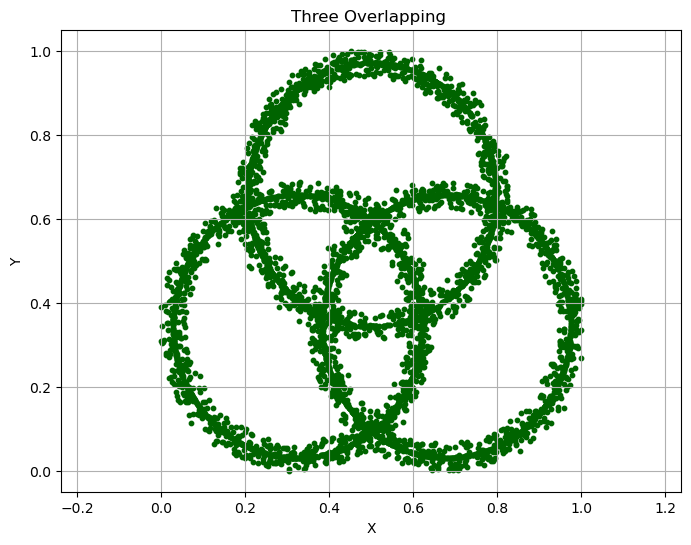

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random points on a circle
def generate_circle_points(center, radius, n_points):
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return np.column_stack((x, y))

# Parameters
n_points_per_circle = 2000
radius = 1.0
distortion_strength = 0.1  # Max distortion in units

# Define centers for three overlapping circles
center1 = (0.0, 0.0)
center2 = (1.2, 0.0)   # Right of center1
center3 = (0.6, 1.0)   # Above and between them to form triangle-style overlap

# Generate points
points1 = generate_circle_points(center1, radius, n_points_per_circle)
points2 = generate_circle_points(center2, radius, n_points_per_circle)
points3 = generate_circle_points(center3, radius, n_points_per_circle)

# Combine all points
xy_points = np.vstack((points1, points2, points3))

# Randomly distort 50% of the points
np.random.seed(42)
n_total = xy_points.shape[0]
n_distort = n_total // 2
distort_indices = np.random.choice(n_total, size=n_distort, replace=False)
distortion = np.random.uniform(-distortion_strength, distortion_strength, size=(n_distort, 2))
xy_points[distort_indices] += distortion

# Normalize to [0, 1]
def normalize_data(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return (data - min_vals) / (max_vals - min_vals)

xy_points_normalized = normalize_data(xy_points)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(xy_points_normalized[:, 0], xy_points_normalized[:, 1], c='darkgreen', s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Three Overlapping ")
plt.axis("equal")
plt.grid(True)
plt.show()


In [17]:
xy_points_normalized

array([[0.46018567, 0.07712009],
       [0.03331989, 0.40159668],
       [0.60462771, 0.24521   ],
       ...,
       [0.3091951 , 0.39568854],
       [0.25148658, 0.48975887],
       [0.70635499, 0.90871675]])

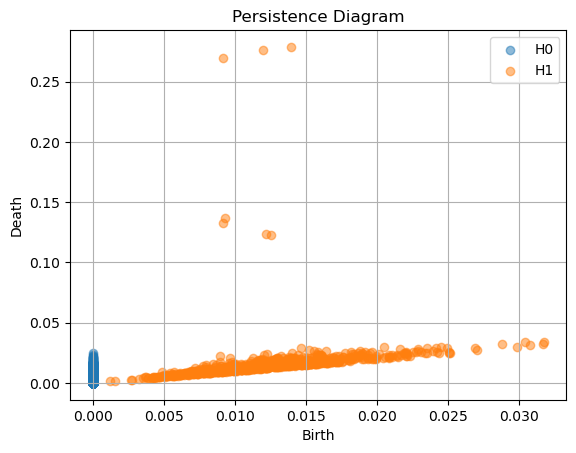

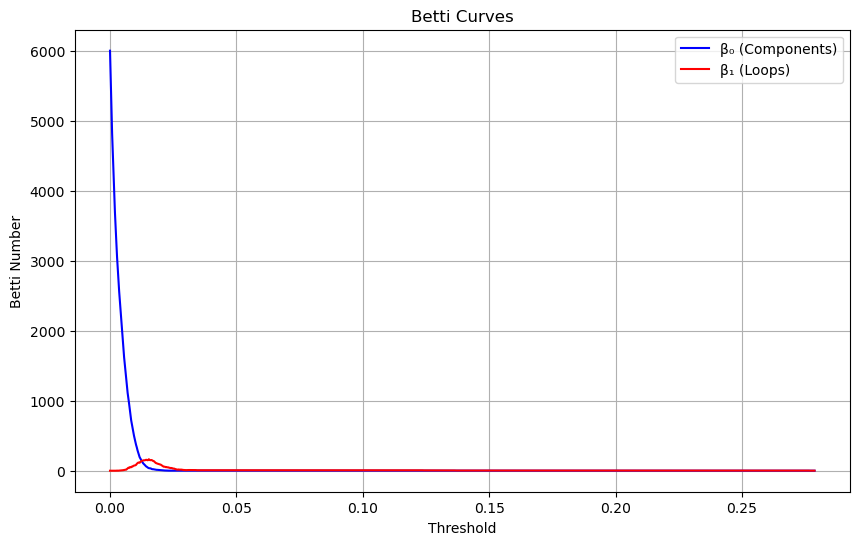

The Betti-1 value 164.0 has a range [0.0153, 0.0153]
The Betti-1 value 157.0 has a range [0.0156, 0.0156]
The Betti-1 value 156.0 has a range [0.0142, 0.0142]
The Betti-1 value 155.0 has a range [0.0145, 0.0145]
The Betti-1 value 153.0 has a range [0.0165, 0.0165]
The Betti-1 value 151.0 has a range [0.0139, 0.0139]
The Betti-1 value 151.0 has a range [0.0151, 0.0151]
The Betti-1 value 151.0 has a range [0.0162, 0.0162]
The Betti-1 value 150.0 has a range [0.0148, 0.0148]
The Betti-1 value 150.0 has a range [0.0159, 0.0159]
The Betti-1 value 149.0 has a range [0.0134, 0.0137]
The Betti-1 value 147.0 has a range [0.0131, 0.0131]
The Betti-1 value 146.0 has a range [0.0167, 0.0167]
The Betti-1 value 142.0 has a range [0.0128, 0.0128]
The Betti-1 value 140.0 has a range [0.0170, 0.0170]
The Betti-1 value 138.0 has a range [0.0126, 0.0126]
The Betti-1 value 138.0 has a range [0.0173, 0.0173]
The Betti-1 value 135.0 has a range [0.0123, 0.0123]
The Betti-1 value 128.0 has a range [0.0176, 0

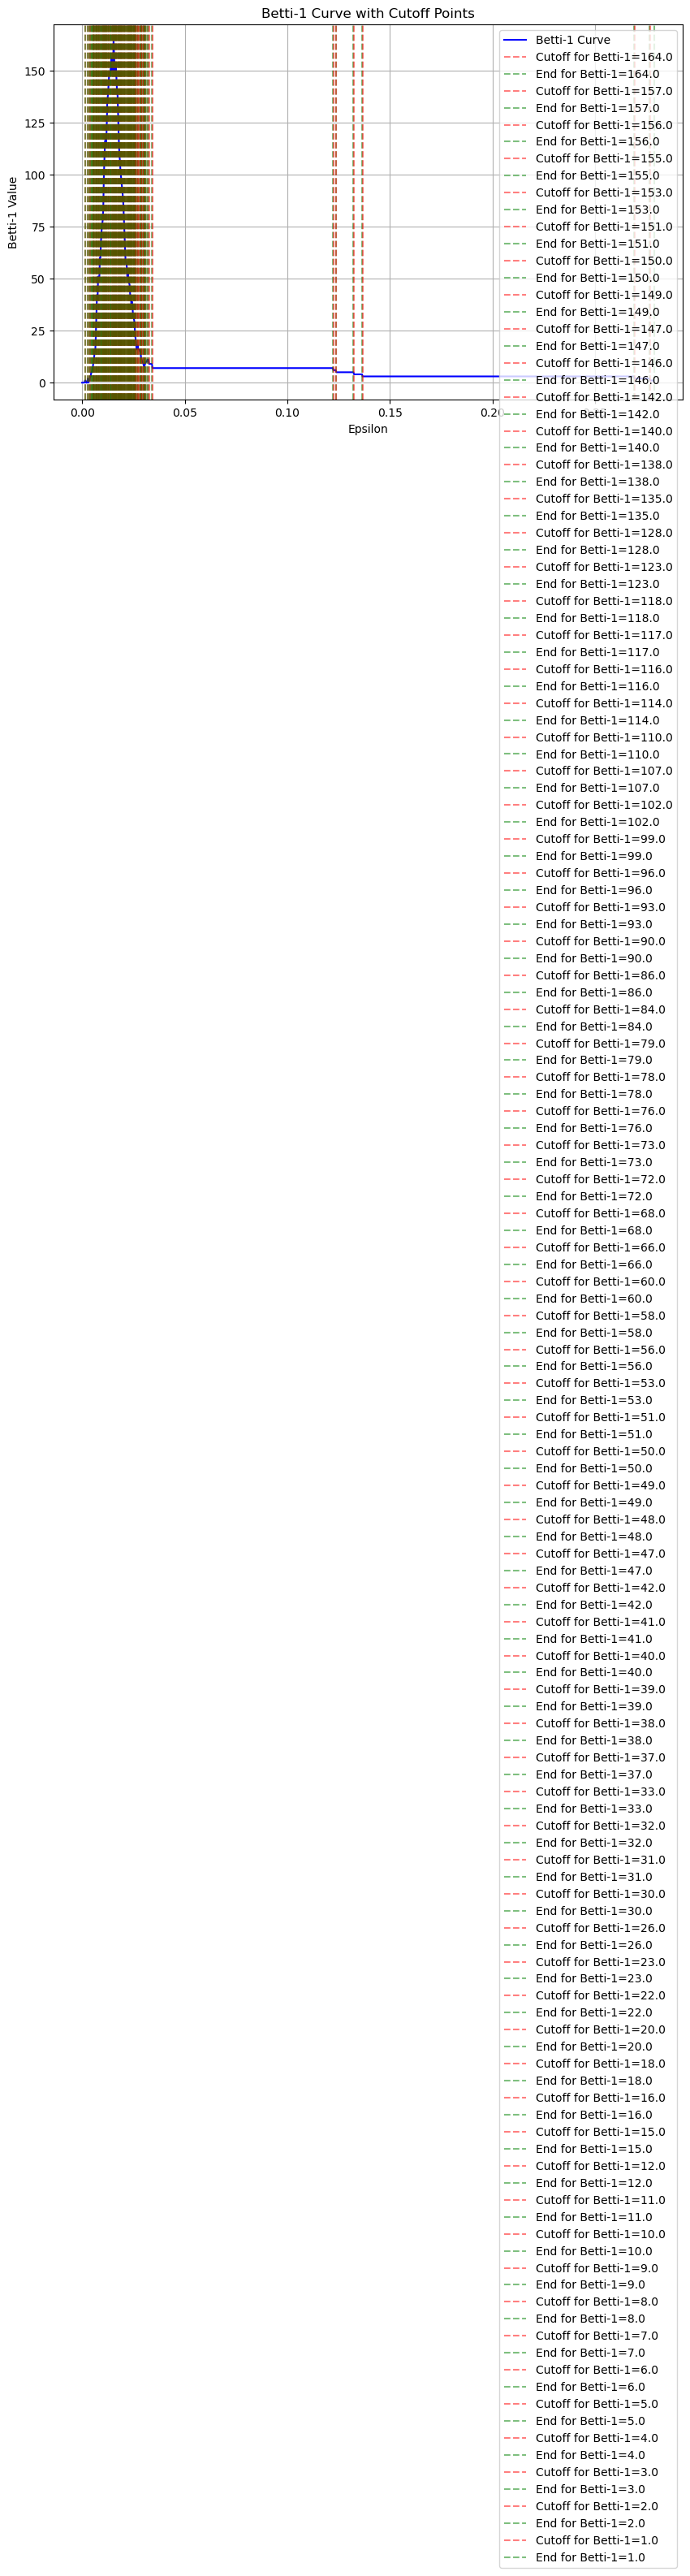

Betti-1 value 164.0 has a total range of 0.0000
Betti-1 value 157.0 has a total range of 0.0000
Betti-1 value 156.0 has a total range of 0.0000
Betti-1 value 155.0 has a total range of 0.0000
Betti-1 value 153.0 has a total range of 0.0000
Betti-1 value 151.0 has a total range of 0.0000
Betti-1 value 150.0 has a total range of 0.0000
Betti-1 value 149.0 has a total range of 0.0003
Betti-1 value 147.0 has a total range of 0.0000
Betti-1 value 146.0 has a total range of 0.0000
Betti-1 value 142.0 has a total range of 0.0000
Betti-1 value 140.0 has a total range of 0.0000
Betti-1 value 138.0 has a total range of 0.0000
Betti-1 value 135.0 has a total range of 0.0000
Betti-1 value 128.0 has a total range of 0.0000
Betti-1 value 123.0 has a total range of 0.0000
Betti-1 value 118.0 has a total range of 0.0000
Betti-1 value 117.0 has a total range of 0.0000
Betti-1 value 116.0 has a total range of 0.0000
Betti-1 value 114.0 has a total range of 0.0000
Betti-1 value 110.0 has a total range of

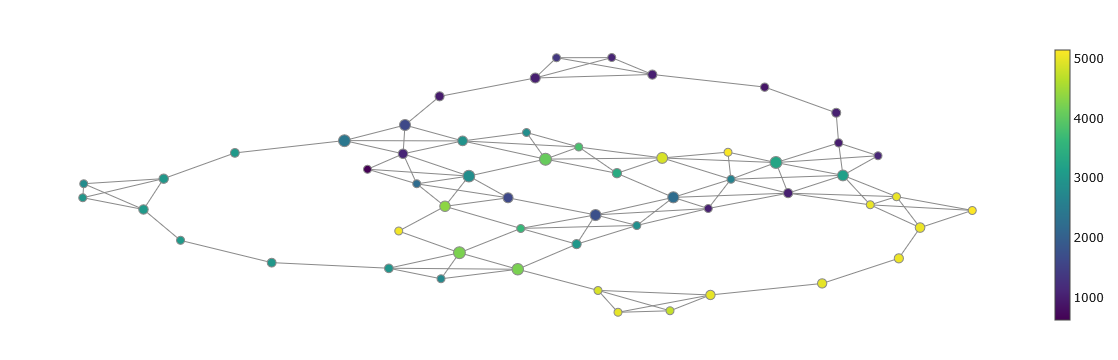


Adjacency Matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


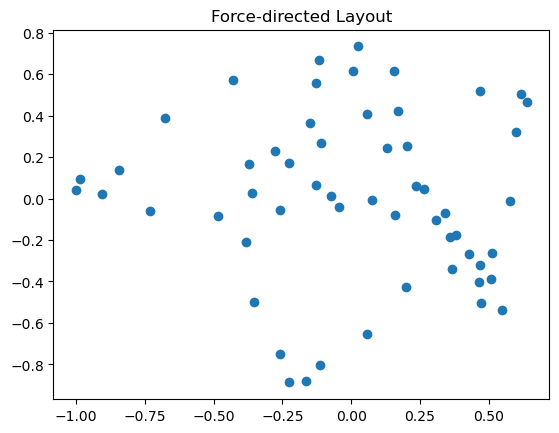

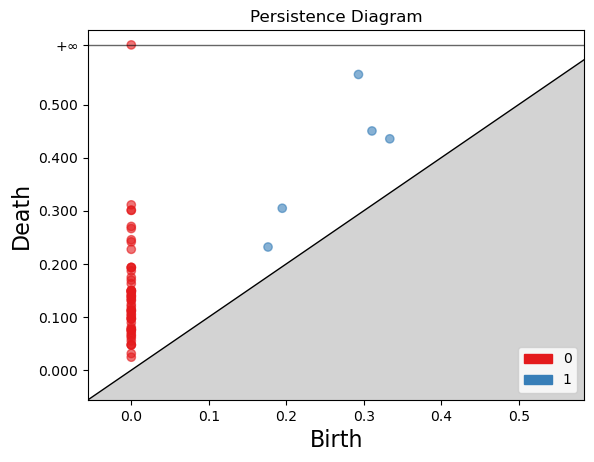

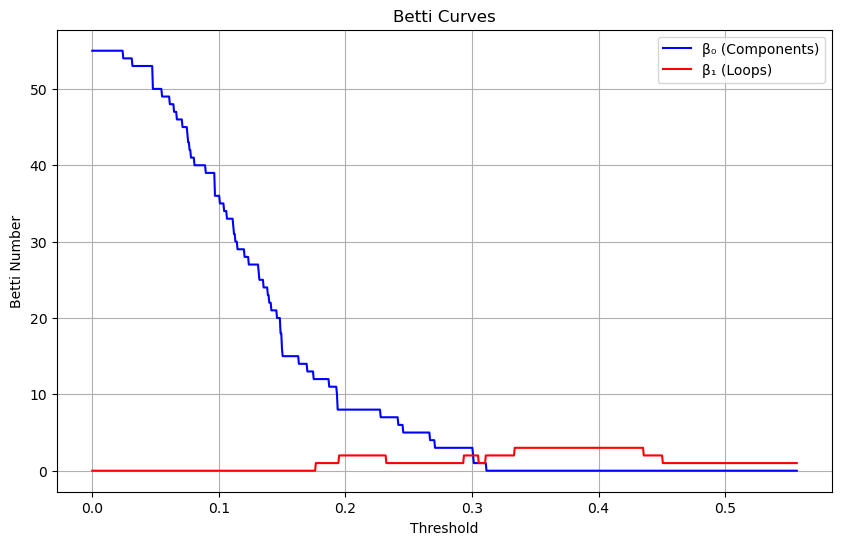

The epsilon (threshold) at which Betti-1 reaches its maximum value of 3.0 is approximately 0.3337
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



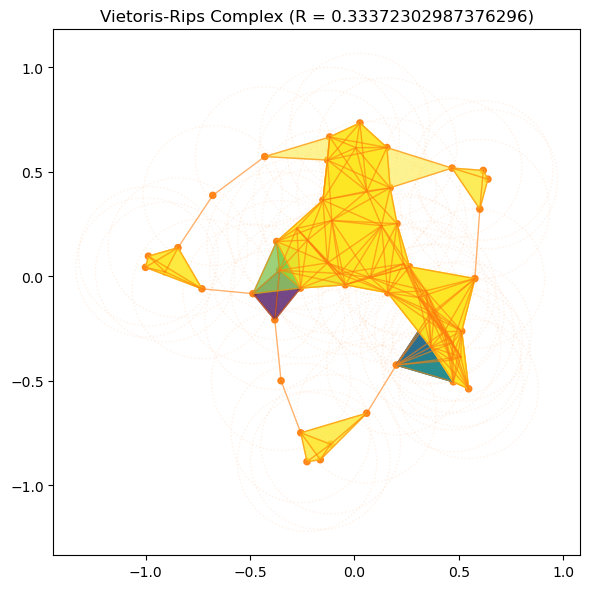

Connected Components: [array([[-0.38130915, -0.20835588],
       [ 0.19998234, -0.42486325],
       [-0.35869617,  0.0290407 ],
       [-0.4855907 , -0.08324925],
       [ 0.38218162, -0.17682587],
       [ 0.36566892, -0.33850002],
       [-0.16368845, -0.87805102],
       [ 0.42926379, -0.26554493],
       [-0.22533729,  0.1729956 ],
       [-0.11408691, -0.80376678],
       [-0.25709907, -0.74924903],
       [-0.10837549,  0.26702465],
       [ 0.26319123,  0.04547727],
       [ 0.05835769, -0.6554207 ],
       [ 0.2351768 ,  0.0594603 ],
       [ 0.1293474 ,  0.24210755],
       [ 0.20345821,  0.25167881],
       [ 0.35871979, -0.18357501],
       [-0.35149831, -0.50000614],
       [ 0.30709382, -0.1018216 ],
       [-0.27621425,  0.22907536],
       [-0.15089127,  0.36429483],
       [-0.37226782,  0.16658056],
       [-0.25843341, -0.05644923],
       [-0.22731038, -0.88720606],
       [ 0.5131191 , -0.26296088],
       [-0.11855546,  0.66656683],
       [-0.72997547, -0.06003822

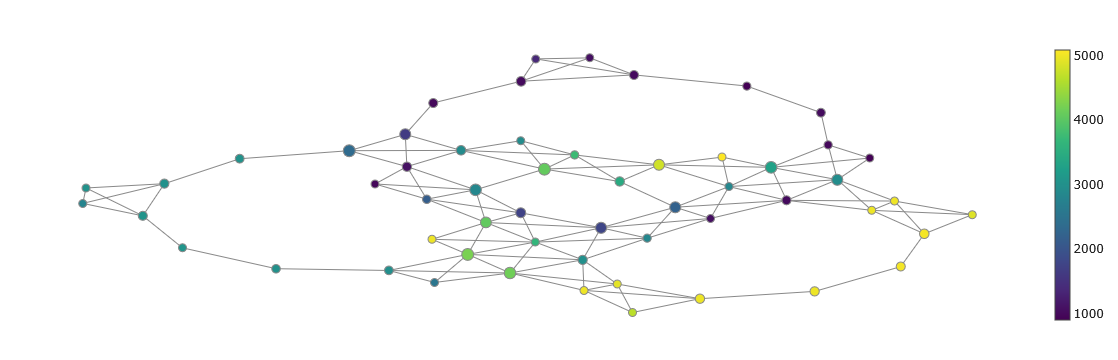


Adjacency Matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


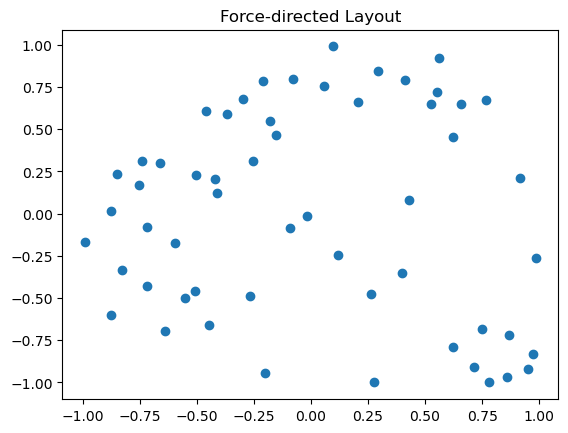

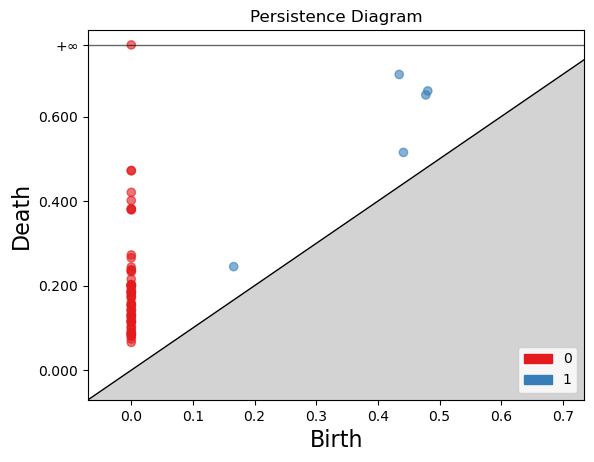

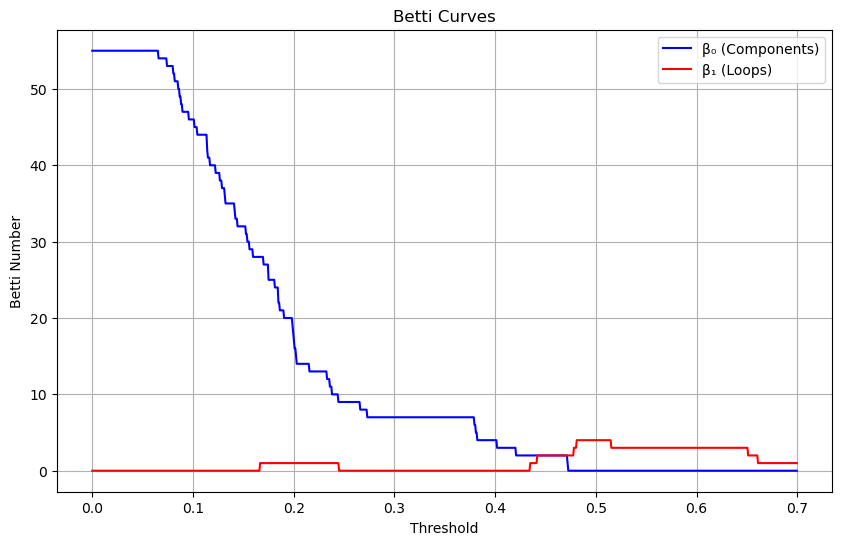

The epsilon (threshold) at which Betti-1 reaches its maximum value of 4.0 is approximately 0.4810
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



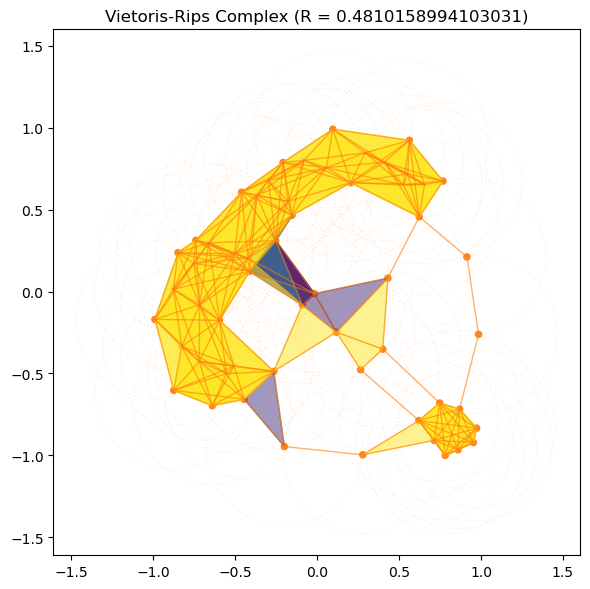

Connected Components: [array([[-0.0162593 , -0.01316109],
       [-0.19991975, -0.9462772 ],
       [-0.25273251,  0.3099737 ],
       [-0.36757123,  0.58781698],
       [-0.09003226, -0.08210319],
       [-0.8262407 , -0.33511172],
       [-0.71918153, -0.42683093],
       [-0.64016328, -0.6964975 ],
       [ 0.97275975, -0.83424556],
       [-0.29764531,  0.67773403],
       [ 0.71420591, -0.9083465 ],
       [ 0.74801073, -0.68079003],
       [-0.20785402,  0.7876401 ],
       [-0.42231173,  0.20291088],
       [ 0.27830233, -0.99663133],
       [-0.50470501,  0.22871194],
       [-0.17808666,  0.54994422],
       [-0.15304935,  0.46562558],
       [-0.59655514, -0.17578264],
       [ 0.40045761, -0.3518039 ],
       [-0.71748969, -0.0809367 ],
       [-0.07977805,  0.80029538],
       [-0.87503607, -0.60317909],
       [-0.46109826,  0.60593599],
       [-0.41249602,  0.123171  ],
       [ 0.95285675, -0.92114601],
       [ 0.05715847,  0.75566939],
       [ 0.65526006,  0.6524675 

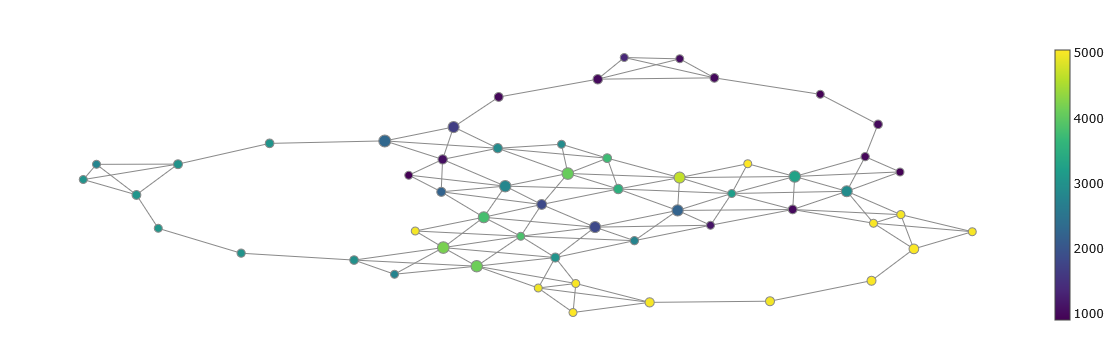


Adjacency Matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


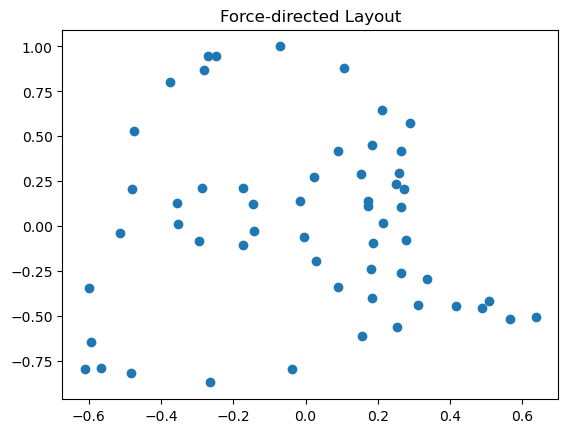

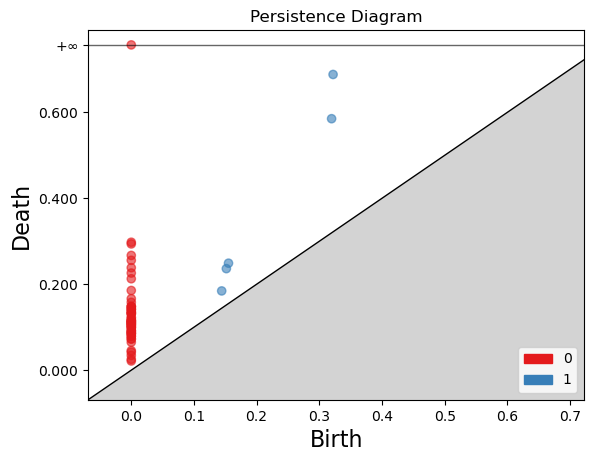

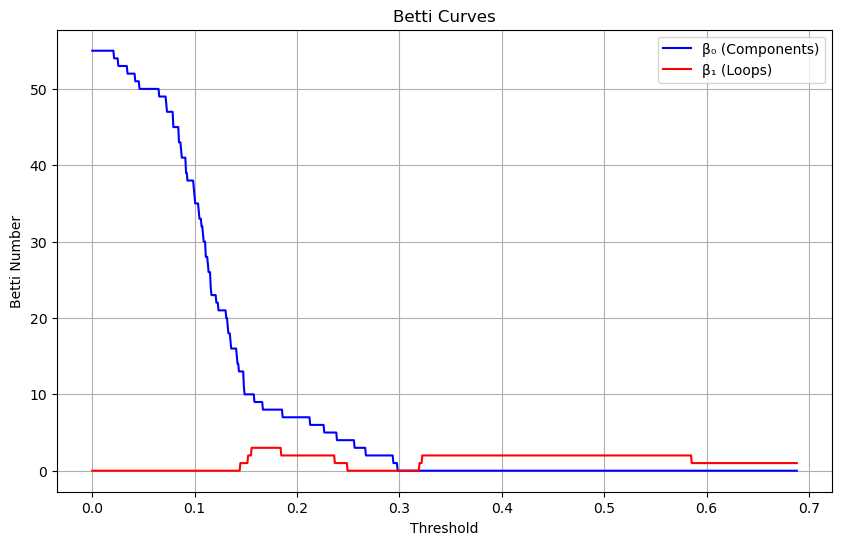

The epsilon (threshold) at which Betti-1 reaches its maximum value of 3.0 is approximately 0.1557
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



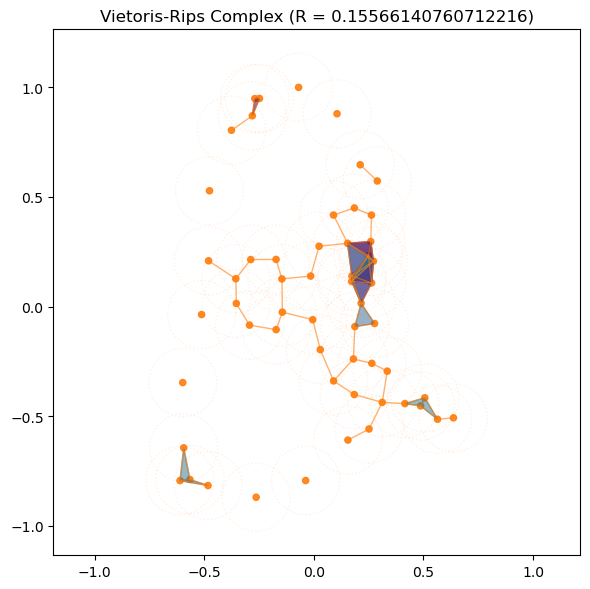

Connected Components: [array([[-0.48020277,  0.20869245],
       [-0.35363912,  0.01414667],
       [-0.14361814, -0.02561579],
       [ 0.18485055,  0.44987524],
       [ 0.26301708,  0.41732916],
       [ 0.25981125,  0.29651884],
       [-0.17203509, -0.10533575],
       [-0.00511153, -0.05987071],
       [ 0.02949851, -0.19650824],
       [ 0.26354799,  0.10762734],
       [ 0.17381632,  0.13946487],
       [ 0.18722636, -0.09147974],
       [ 0.27707332, -0.07742701],
       [ 0.15389907,  0.28839719],
       [-0.29352168, -0.08465781],
       [-0.35598699,  0.1269657 ],
       [ 0.18051352, -0.23914268],
       [ 0.15549264, -0.60912891],
       [ 0.33484396, -0.29479657],
       [-0.17233967,  0.21506393],
       [-0.14555404,  0.12603747],
       [-0.2878736 ,  0.21442216],
       [ 0.18447852, -0.40150897],
       [ 0.31209308, -0.43720986],
       [-0.01446884,  0.13917231],
       [ 0.02386554,  0.27511138],
       [ 0.25170781, -0.55860627],
       [ 0.4869332 , -0.45331816

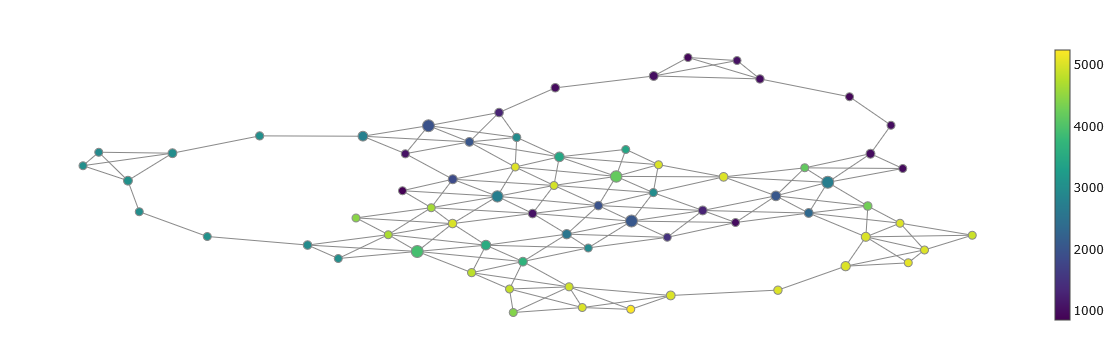


Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


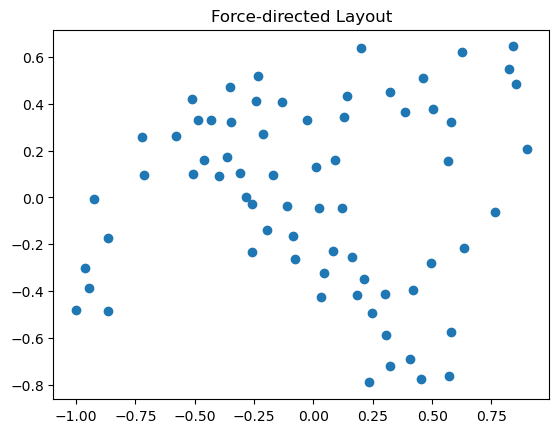

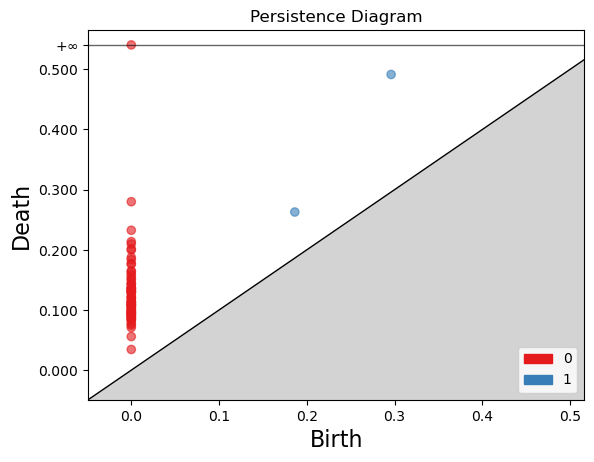

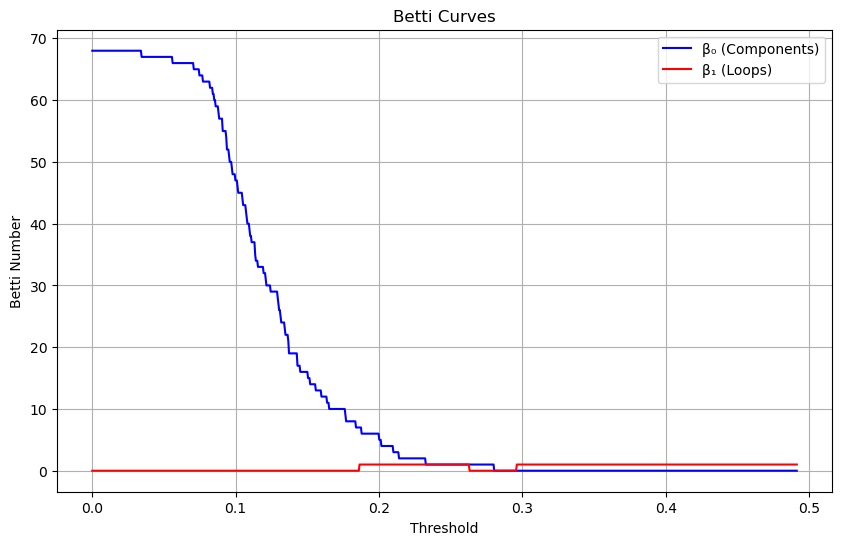

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.1864
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



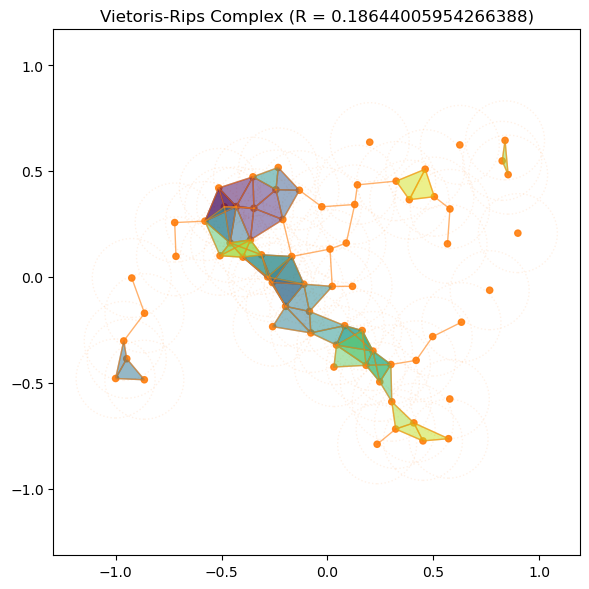

Connected Components: [array([[-7.21002136e-01,  2.56419489e-01],
       [-5.12959479e-01,  4.19783010e-01],
       [-7.14921458e-01,  9.69980018e-02],
       [-3.47102388e-01,  3.23843884e-01],
       [-2.60038158e-01, -2.65823123e-02],
       [-1.32207507e-01,  4.08856710e-01],
       [-4.30668586e-01,  3.31827054e-01],
       [-2.65907849e-02,  3.31073927e-01],
       [-1.97435271e-01, -1.39400403e-01],
       [ 1.23034662e-02,  1.31221869e-01],
       [ 8.89874425e-02,  1.59699675e-01],
       [ 2.28097259e-02, -4.47070422e-02],
       [ 1.18481893e-01, -4.48233390e-02],
       [-4.86529770e-01,  3.30465513e-01],
       [-8.46543700e-02, -1.63230426e-01],
       [ 1.41757918e-01,  4.34485304e-01],
       [ 1.28959668e-01,  3.41677979e-01],
       [-3.51403939e-01,  4.72359916e-01],
       [-2.32098052e-01,  5.16450841e-01],
       [-7.81814357e-02, -2.64654220e-01],
       [ 8.15630841e-02, -2.30475236e-01],
       [-1.11418384e-01, -3.45688129e-02],
       [-2.42872378e-01,  4.117

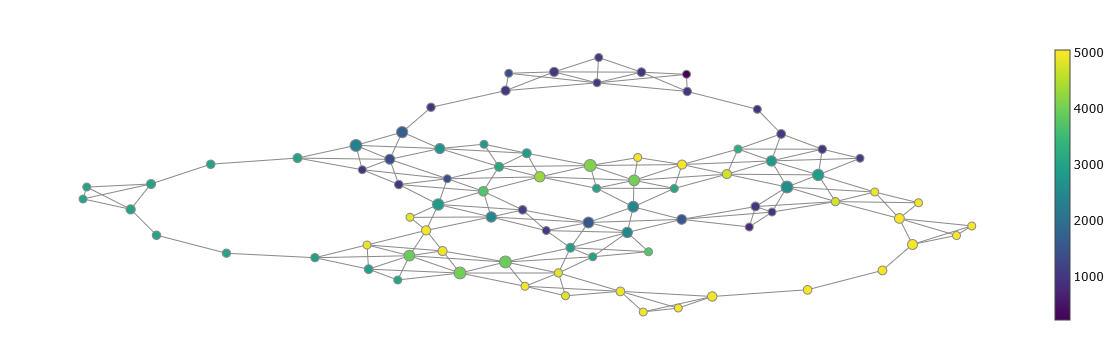


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


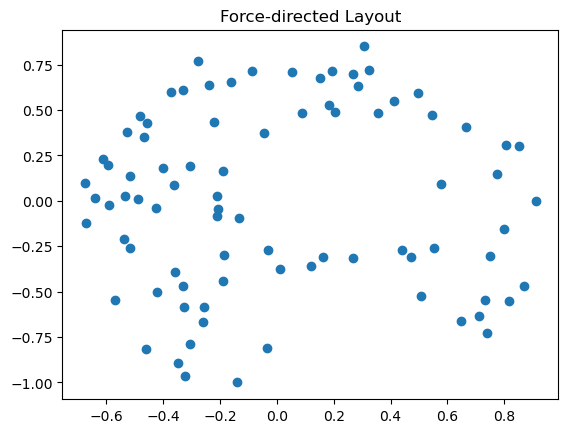

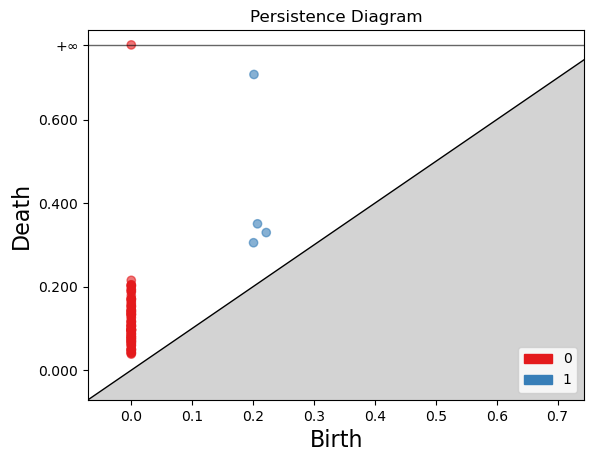

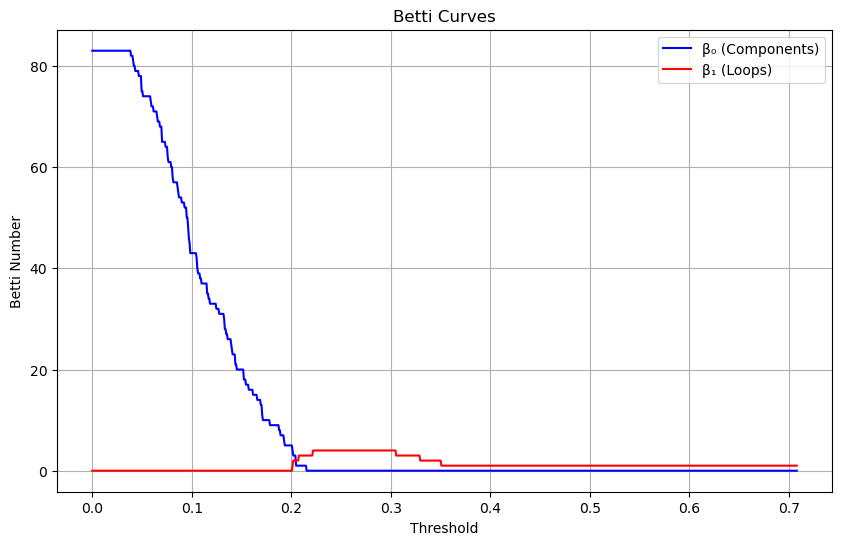

The epsilon (threshold) at which Betti-1 reaches its maximum value of 4.0 is approximately 0.2218
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



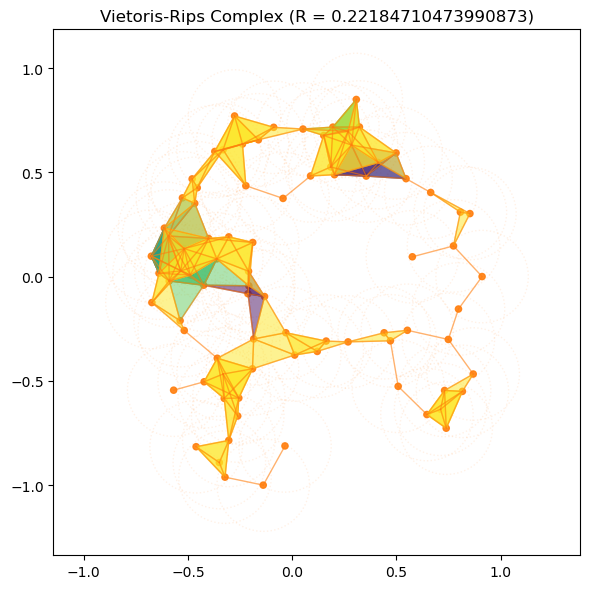

Connected Components: [array([[-2.12294987e-01, -8.16267031e-02],
       [ 5.76257876e-01,  9.55390425e-02],
       [ 3.54929497e-01,  4.82814468e-01],
       [-5.93541749e-01,  1.95222194e-01],
       [-6.75843957e-01,  9.85278221e-02],
       [-4.24611173e-01, -4.07632730e-02],
       [ 1.95064412e-01,  7.17706462e-01],
       [ 3.22317143e-01,  7.18339805e-01],
       [ 2.67976518e-01,  6.97331378e-01],
       [ 7.38678455e-01, -7.26834062e-01],
       [ 8.16318183e-01, -5.50261619e-01],
       [ 7.11684584e-01, -6.36248211e-01],
       [ 7.30882365e-01, -5.45810012e-01],
       [ 2.84468629e-01,  6.31485700e-01],
       [ 7.48874323e-01, -3.01029671e-01],
       [-5.18681664e-01,  1.34677206e-01],
       [-5.34742329e-01,  2.75599274e-02],
       [-4.41450900e-02,  3.75678126e-01],
       [-4.01356097e-01,  1.83376918e-01],
       [-4.89162035e-01,  8.01614321e-03],
       [-3.04511931e-01,  1.91020174e-01],
       [-3.62177951e-01,  8.54116377e-02],
       [ 2.02691528e-01,  4.893

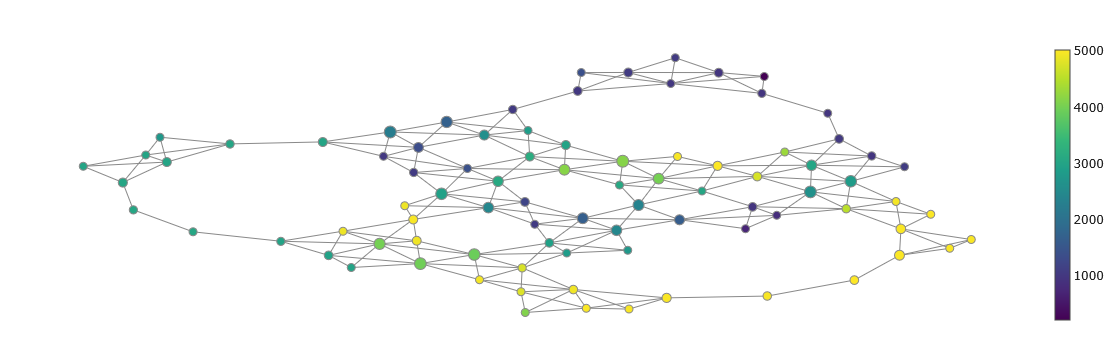


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


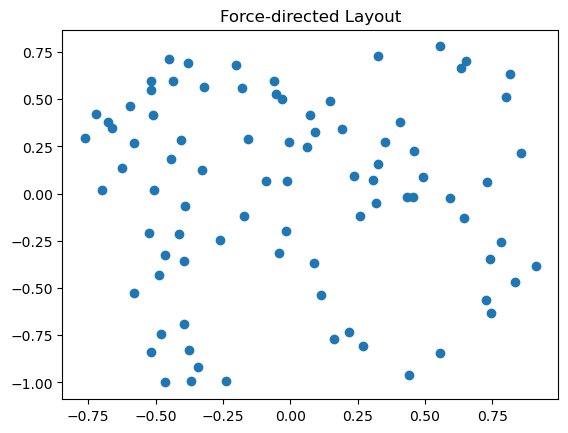

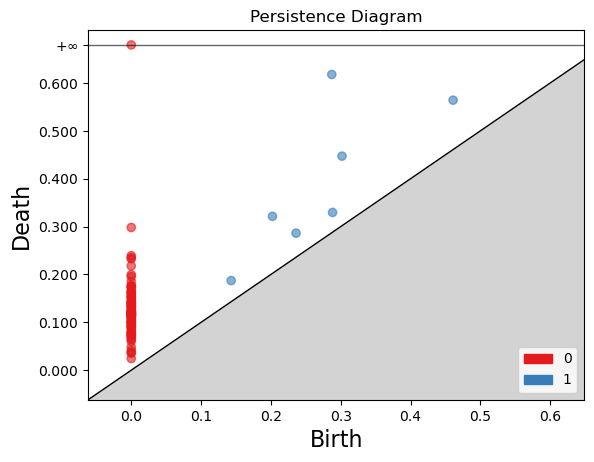

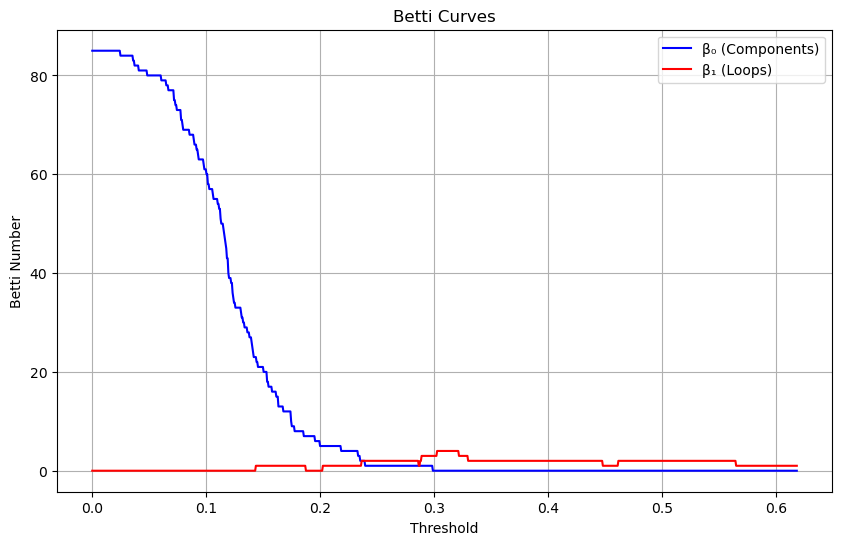

The epsilon (threshold) at which Betti-1 reaches its maximum value of 4.0 is approximately 0.3024
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



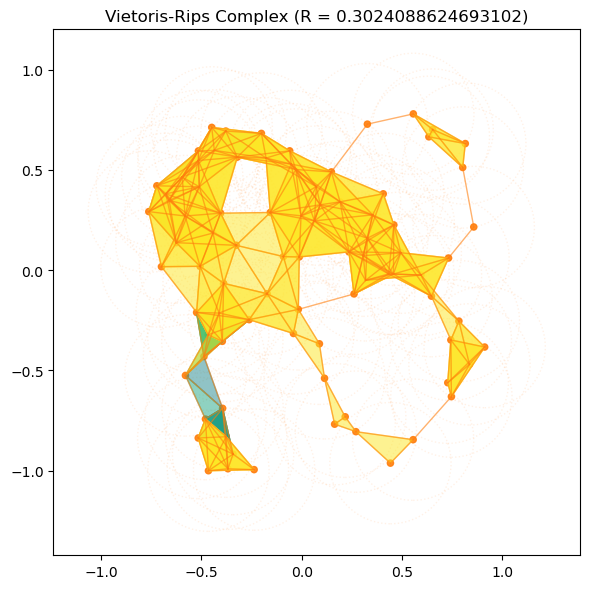

Connected Components: [array([[-0.66103915,  0.34779196],
       [-0.3944745 , -0.68894233],
       [-0.48749056, -0.4304343 ],
       [-0.43572336,  0.59726624],
       [-0.37860921,  0.69363749],
       [-0.51535791,  0.54665842],
       [-0.41129526, -0.21395028],
       [-0.26195667, -0.24683116],
       [-0.46627256, -0.32247376],
       [-0.46508322, -1.        ],
       [-0.36793395, -0.99017042],
       [-0.51605749, -0.83684589],
       [-0.37673277, -0.8304533 ],
       [-0.17259329, -0.1173982 ],
       [-0.34235353, -0.91710433],
       [-0.3213646 ,  0.56354595],
       [-0.06006252,  0.59488685],
       [-0.17775263,  0.55894349],
       [-0.0524838 ,  0.52871026],
       [-0.00347148,  0.27084428],
       [-0.67744788,  0.38058593],
       [-0.5151463 ,  0.59461549],
       [ 0.07268549,  0.41627229],
       [ 0.14786889,  0.48991062],
       [-0.09123088,  0.06766737],
       [ 0.1912629 ,  0.34080679],
       [-0.0169386 , -0.19563901],
       [-0.01225168,  0.06596685

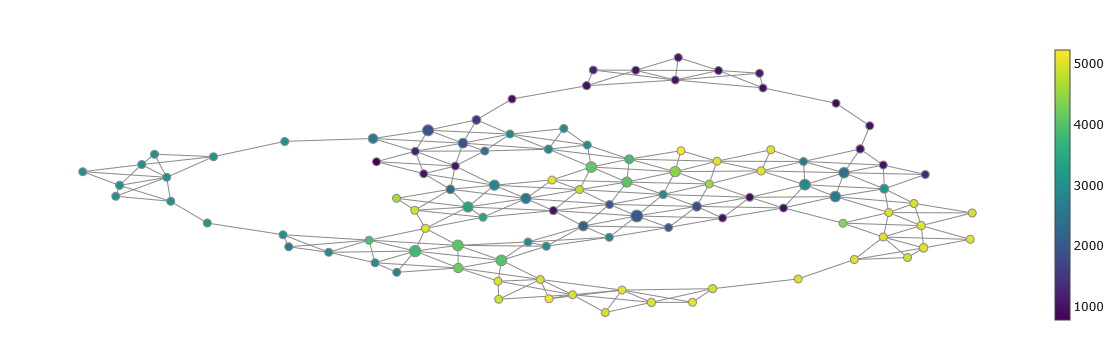


Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


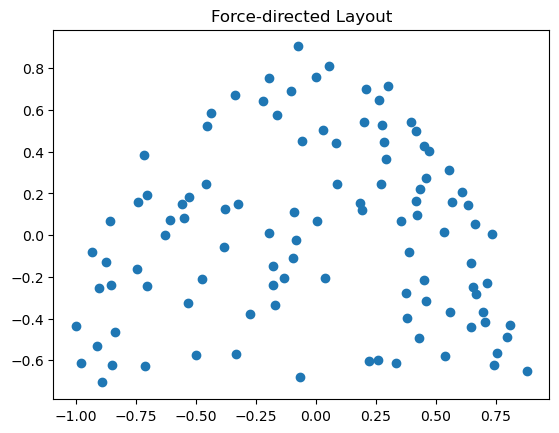

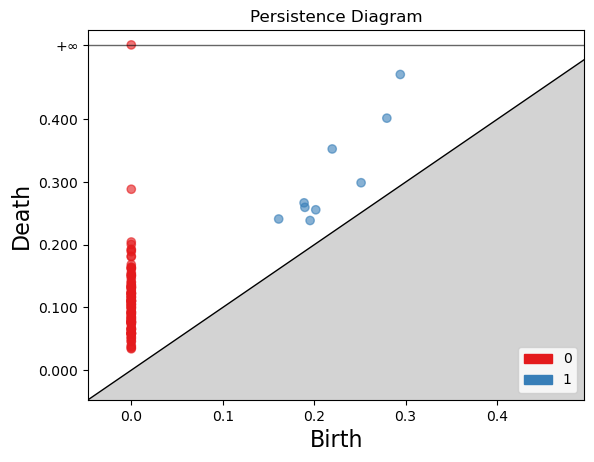

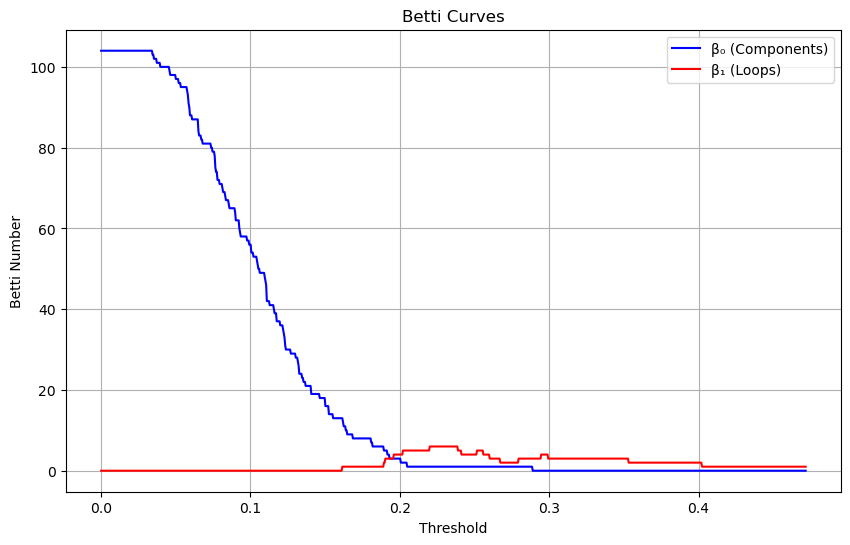

The epsilon (threshold) at which Betti-1 reaches its maximum value of 6.0 is approximately 0.2200
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



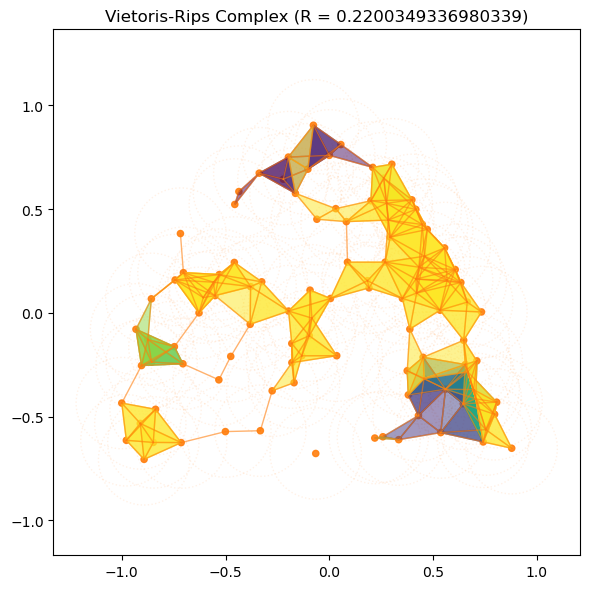

Connected Components: [array([[-4.35596983e-01,  5.84427656e-01],
       [-3.37402304e-01,  6.73064880e-01],
       [ 1.78909874e-04,  7.58847829e-01],
       [ 5.60033575e-02,  8.10879586e-01],
       [-2.21338529e-01,  6.44091271e-01],
       [ 4.29749813e-01, -4.95294102e-01],
       [ 5.37385121e-01, -5.77315067e-01],
       [ 5.60305505e-01, -3.68021178e-01],
       [ 6.45745469e-01, -4.38322712e-01],
       [ 2.19476485e-01, -6.03606902e-01],
       [ 3.34802652e-01, -6.11444784e-01],
       [-8.55813531e-01, -2.37624533e-01],
       [-7.05393740e-01, -2.45628548e-01],
       [-8.74375750e-01, -1.29021976e-01],
       [-7.46542854e-01, -1.63231089e-01],
       [ 2.62601317e-01,  6.48919108e-01],
       [ 2.09540541e-01,  7.00705472e-01],
       [ 3.81019124e-01, -3.95815496e-01],
       [-5.32086372e-01, -3.23175144e-01],
       [ 3.98223059e-01,  5.44395336e-01],
       [ 2.76775283e-01,  5.27959871e-01],
       [ 6.64908611e-01,  5.15722309e-02],
       [ 7.33603209e-01,  4.126

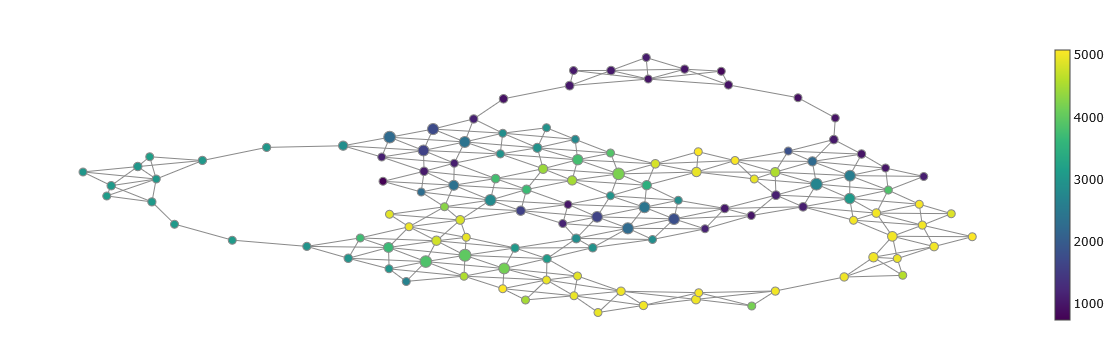


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


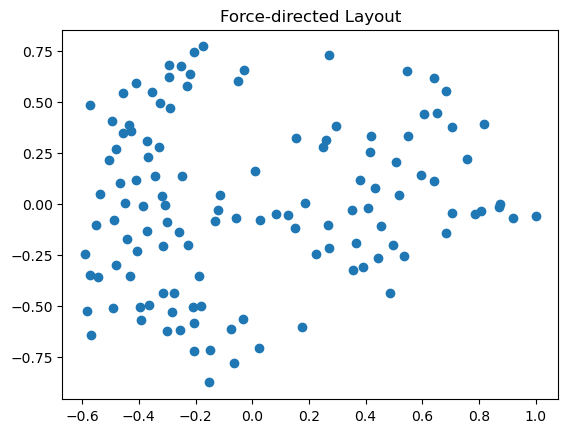

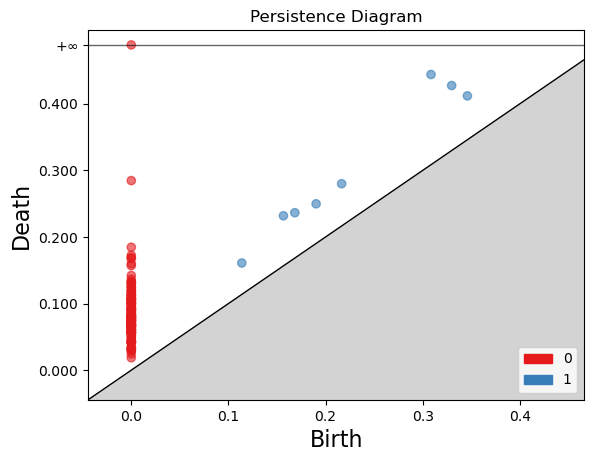

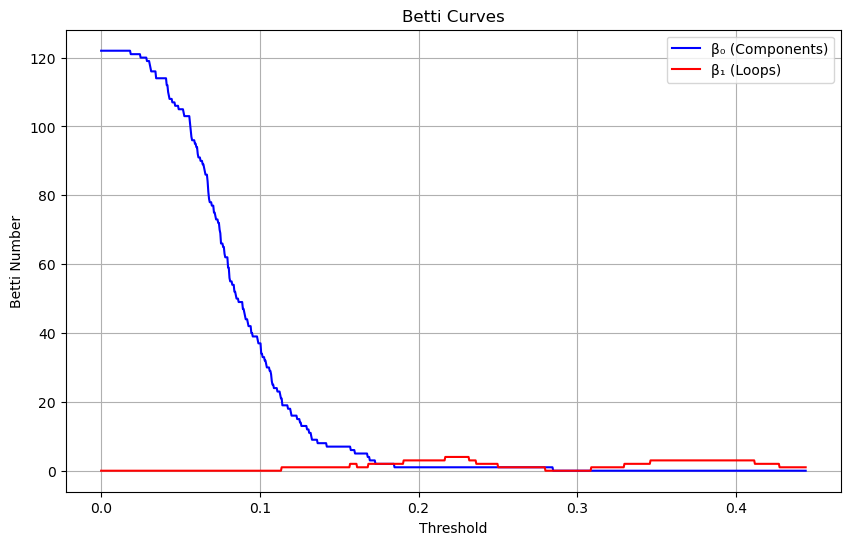

The epsilon (threshold) at which Betti-1 reaches its maximum value of 4.0 is approximately 0.2169
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



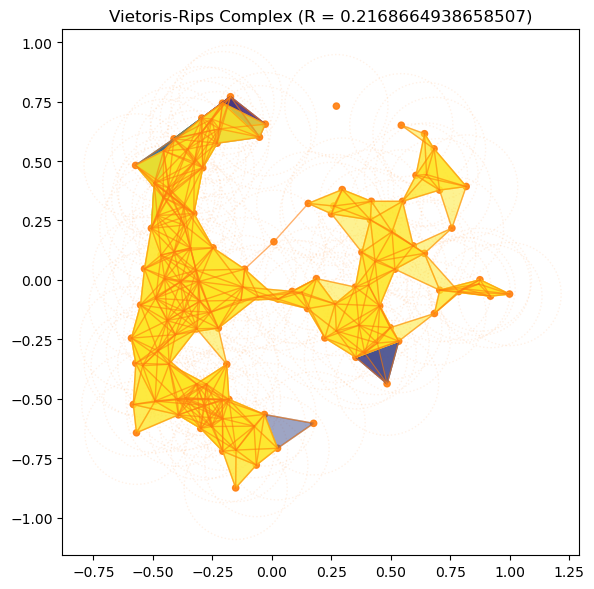

Connected Components: [array([[-1.73815170e-01,  7.70399140e-01],
       [ 4.84753881e-01, -4.36696926e-01],
       [ 1.75859119e-01, -6.03268266e-01],
       [-4.11450161e-01,  5.93300434e-01],
       [-4.94555845e-01,  4.06442947e-01],
       [-4.55021436e-01,  5.42731895e-01],
       [-4.35117613e-01,  3.87586591e-01],
       [-2.52416804e-01,  6.76561408e-01],
       [-2.07112142e-01,  7.43293323e-01],
       [-2.94273592e-01,  6.80622230e-01],
       [-1.50416433e-01, -7.15751962e-01],
       [-2.53389323e-01, -6.16688694e-01],
       [ 2.41216736e-02, -7.08318296e-01],
       [-3.11999929e-02, -5.65988782e-01],
       [-7.45908867e-02, -6.15123758e-01],
       [ 6.06439369e-01,  4.39724636e-01],
       [ 7.05429214e-01,  3.77752225e-01],
       [ 6.82352510e-01,  5.51124962e-01],
       [ 6.50856036e-01,  4.42962294e-01],
       [-2.98991718e-01, -6.24513951e-01],
       [-3.63109413e-01, -4.96638702e-01],
       [-3.96881335e-01, -5.02946627e-01],
       [ 5.44604584e-01,  6.505

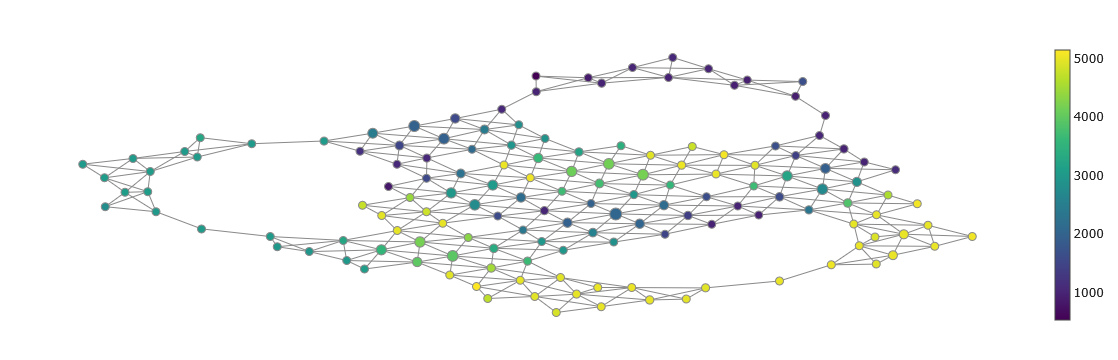


Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


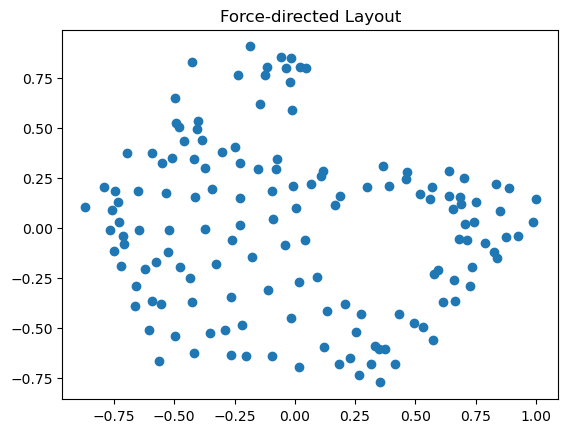

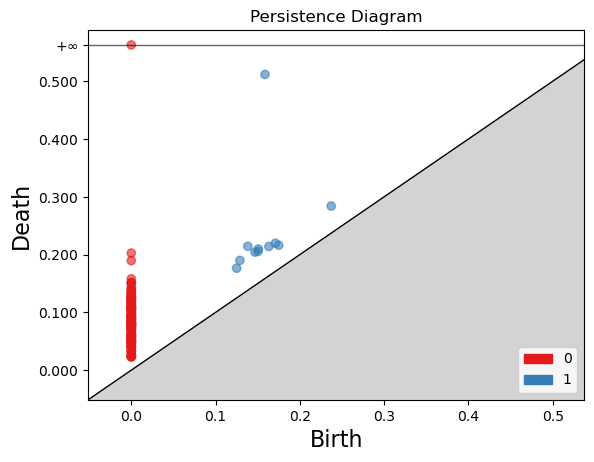

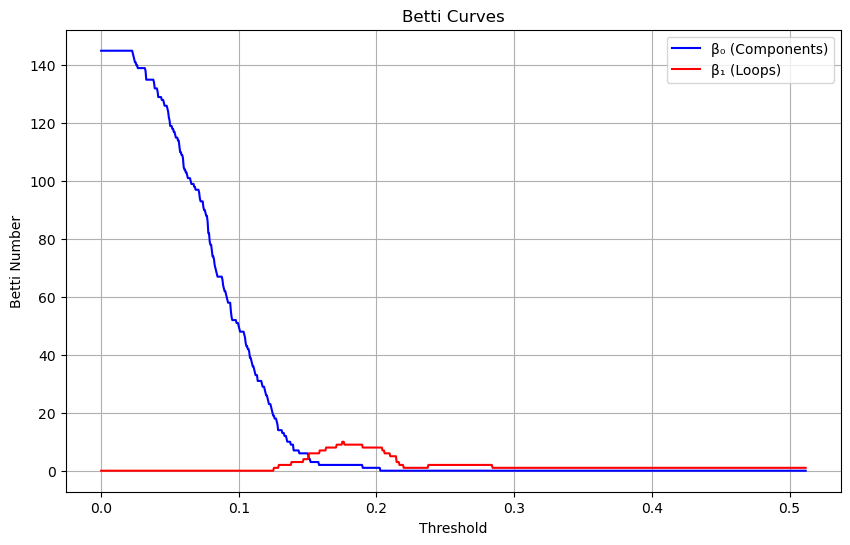

The epsilon (threshold) at which Betti-1 reaches its maximum value of 10.0 is approximately 0.1752
Betti condition is not satisfied.
For alpha = 55%, N = 15


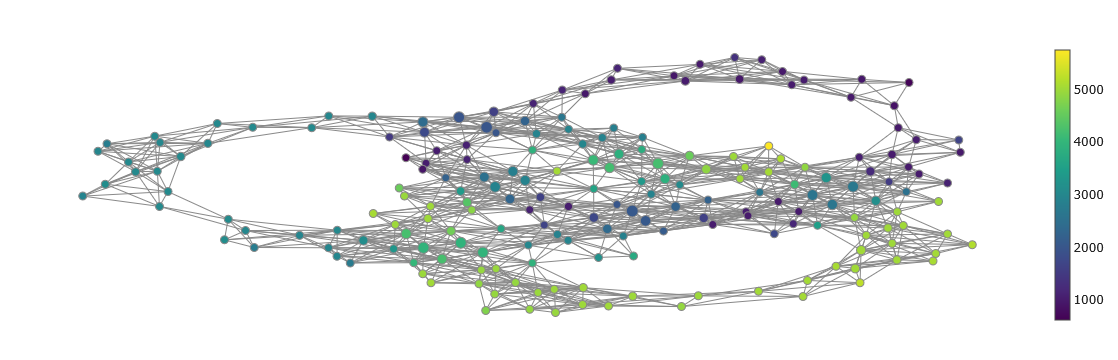


Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


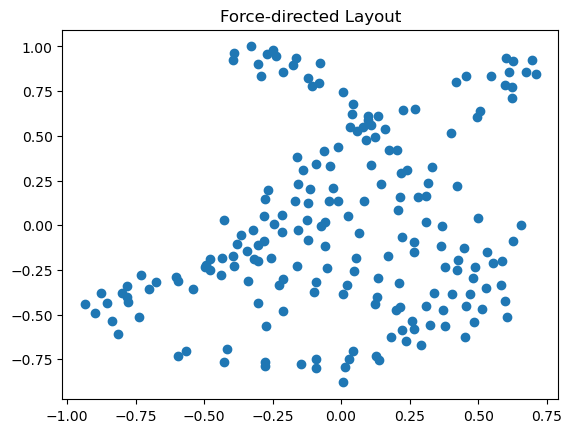

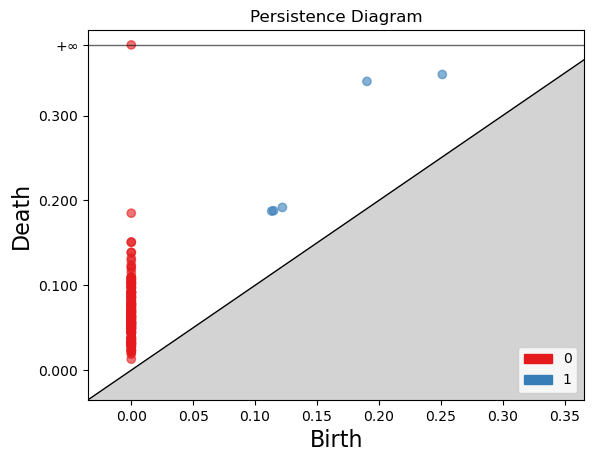

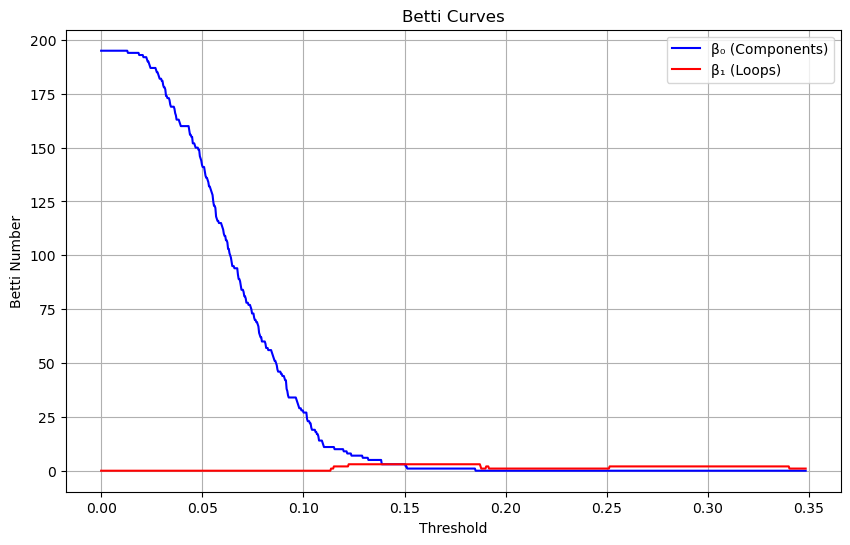

The epsilon (threshold) at which Betti-1 reaches its maximum value of 3.0 is approximately 0.1224
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



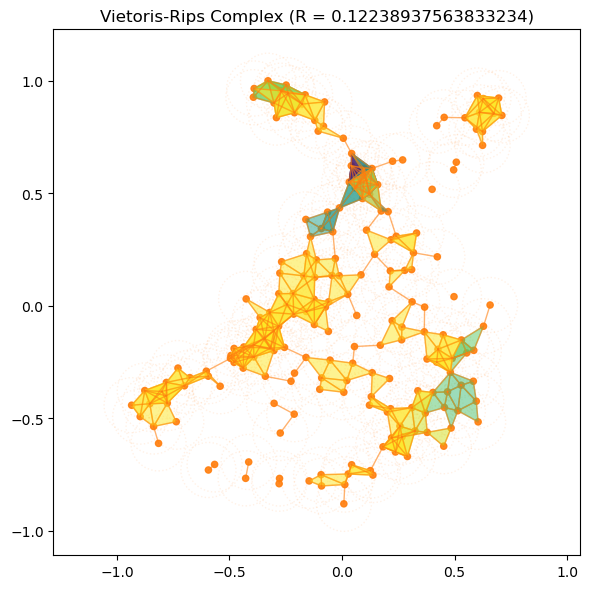

Connected Components: [array([[ 0.04141108,  0.62233284],
       [ 0.07869869,  0.54897429],
       [ 0.09630643,  0.60986085],
       [ 0.12264716,  0.49591222],
       [ 0.42359655,  0.2178638 ],
       [-0.01087285,  0.43537164],
       [-0.04096167,  0.32882199],
       [-0.06417121,  0.41637028],
       [-0.09154849,  0.34350081],
       [ 0.09960774,  0.5875233 ],
       [ 0.05847618,  0.52435882],
       [ 0.52954883, -0.35271098],
       [ 0.51486559, -0.46608994],
       [ 0.46886621, -0.38211724],
       [ 0.45509462, -0.45135865],
       [ 0.58562556, -0.19769322],
       [ 0.58362402, -0.33516707],
       [ 0.55413322, -0.20935929],
       [ 0.62870407, -0.09068063],
       [-0.39367994,  0.92698281],
       [-0.24812136,  0.98088528],
       [-0.32884545,  1.        ],
       [-0.23903656,  0.94468313],
       [ 0.37878824, -0.56225565],
       [ 0.37021051, -0.47645756],
       [ 0.3242727 , -0.55580102],
       [-0.02964389,  0.21015692],
       [-0.11387035,  0.2041381 

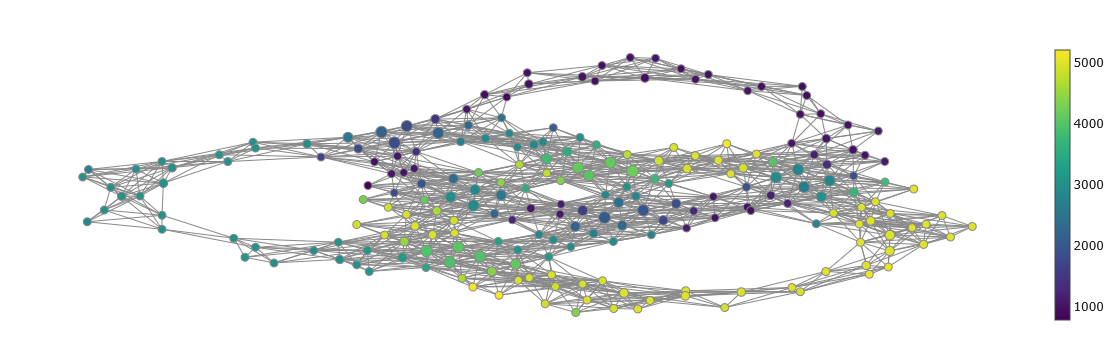


Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


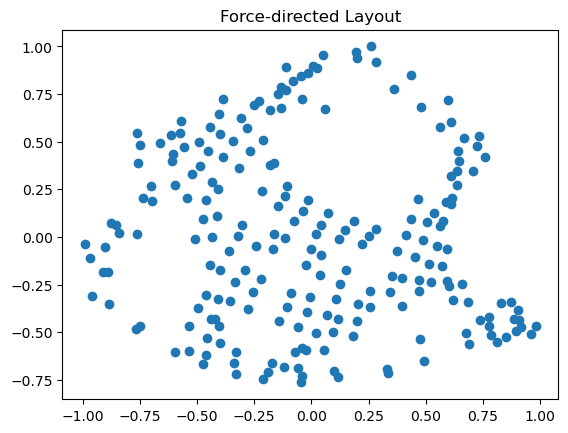

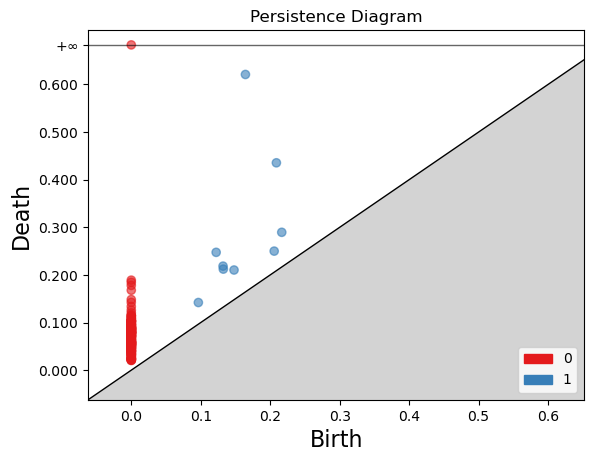

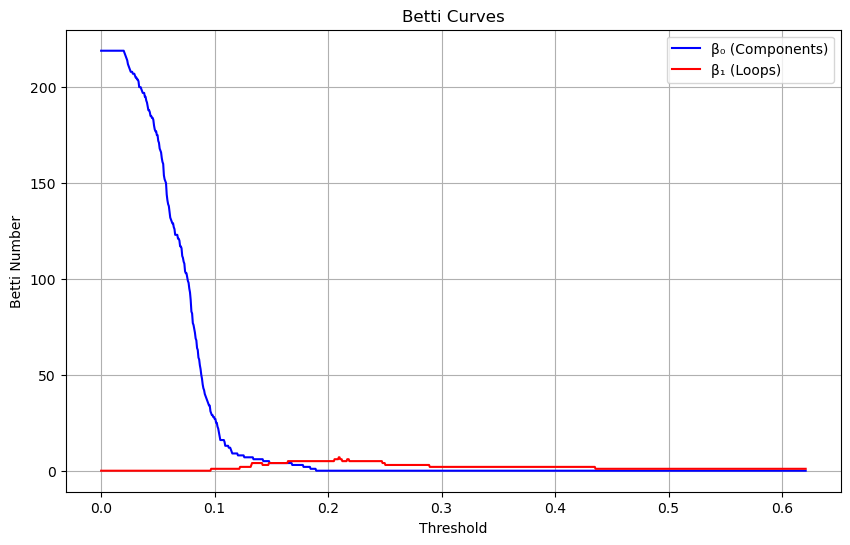

The epsilon (threshold) at which Betti-1 reaches its maximum value of 7.0 is approximately 0.2094
Betti condition is satisfied.


C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\SU Mathematics\AppData\Local\Temp\ipykernel_5920\2167933088.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



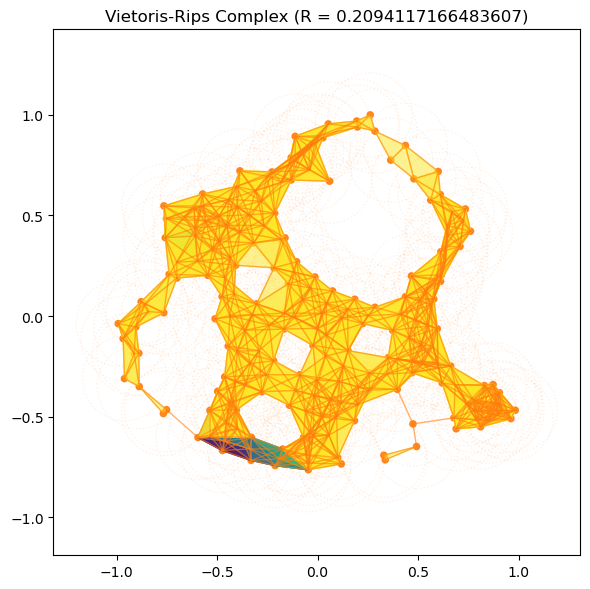

Connected Components: [array([[-4.73236382e-01, -6.68672886e-01],
       [-4.61438229e-01, -6.22551322e-01],
       [-3.30897598e-01, -7.17758835e-01],
       [-3.37219336e-01, -6.60569647e-01],
       [-2.11540614e-01, -7.43791501e-01],
       [-1.89170973e-01, -7.10129009e-01],
       [-6.09728252e-01,  3.97959598e-01],
       [-7.51669966e-01,  4.84973001e-01],
       [-6.62243452e-01,  4.94111611e-01],
       [-1.18507786e-01, -6.81777202e-01],
       [-2.25249498e-02, -5.96153139e-01],
       [-6.05477701e-02, -4.72236384e-01],
       [-5.97855885e-02, -6.88534588e-01],
       [-3.92757321e-02, -5.81228416e-01],
       [ 2.09742907e-02, -5.02326589e-01],
       [-4.90044090e-01,  4.97005945e-01],
       [-4.42504069e-01,  5.79315825e-01],
       [-4.51487497e-01,  4.50926423e-01],
       [-3.99908091e-01,  5.40981217e-01],
       [-3.86112969e-01,  4.19056107e-01],
       [-3.41168737e-01,  5.03683023e-01],
       [-6.14320857e-01,  5.37356910e-01],
       [-5.76236347e-01,  5.468

In [21]:
xy_points = xy_points_normalized
k = .8  # Example value for k
cutoff_betti = 4 # Example cutoff Betti value
results_df_torus = process_correlation_matrix(xy_points, k, cutoff_betti)